In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import os
print(os.getcwd())

img = cv2.imread('.././photos_test/guilhem_board/0.jpg',1)
print(type(img))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img)
plt.show()
plt.imshow(img_gray, cmap = 'gray')
plt.show()


/Users/Mathian/Documents/IA/Vision_par_ordinateur/VisualChess/documentation/code
<class 'NoneType'>


error: OpenCV(4.1.1) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


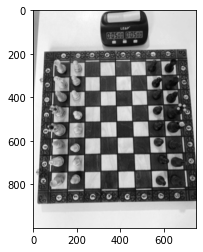

In [3]:
kernel_size = 3
sigma = 1.4

gaussian_blur = cv2.GaussianBlur(img_gray,(5,5),1.4,1.4,cv2.BORDER_DEFAULT)

plt.imshow(gaussian_blur, cmap = 'gray')
plt.show()

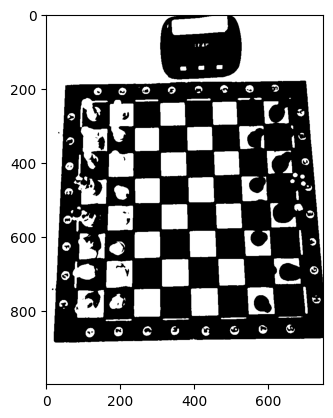

In [16]:
def apply_binary_threshold(img, threshold):
    height, width = img.shape
    binary_image = np.copy(img)
    for i in range(height):
        for j in range(width):
            if img[i,j] >=threshold:
                binary_image[i,j] = 255
            else :
                binary_image[i,j] = 0
    return binary_image

threshold = 128
binary_img = apply_binary_threshold(gaussian_blur, threshold)
plt.imshow(binary_img, cmap = 'gray')
plt.show()

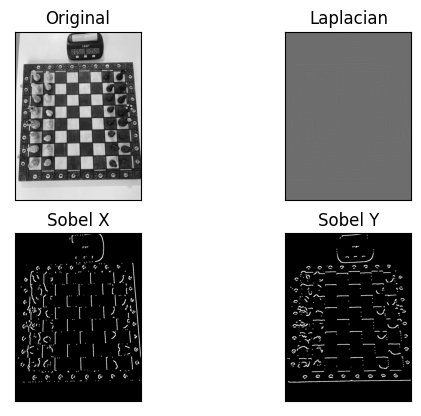

In [28]:
# avec le laplacian
laplacian = cv2.Laplacian(binary_img,cv2.CV_64F)

# avec sobel
sobelx = cv2.Sobel(binary_img,cv2.CV_8UC1,1,0,ksize=5)
sobely = cv2.Sobel(binary_img,cv2.CV_8UC1,0,1,ksize=5)



plt.subplot(2,2,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

# Sobel transformations

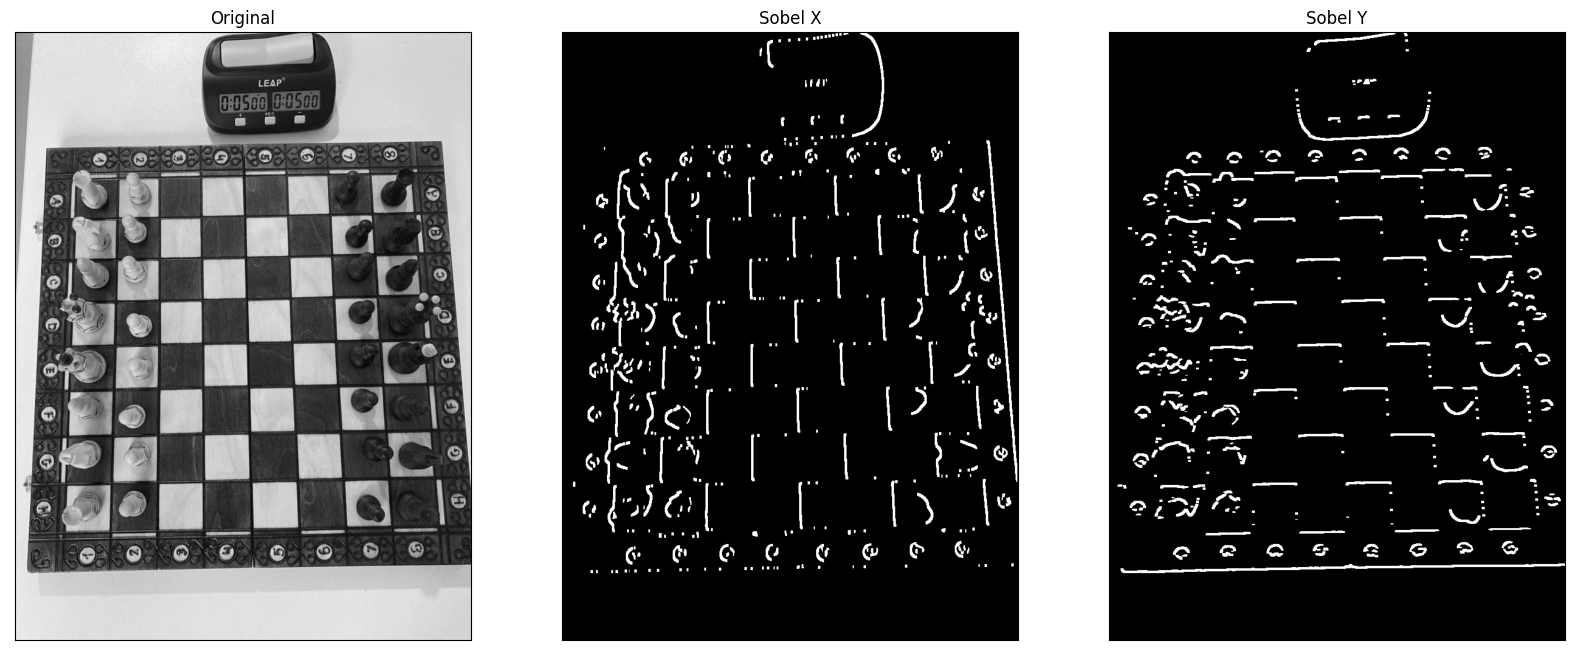

In [29]:
plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

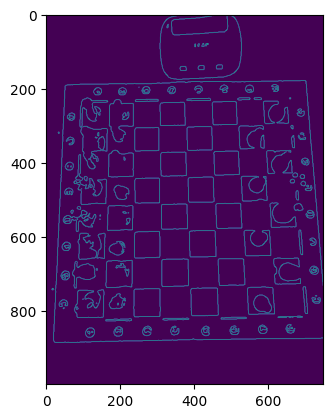

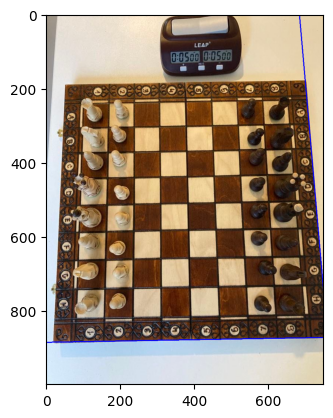

In [30]:
edges = cv2.Canny(binary_img,50,150,apertureSize = 3)

plt.imshow(edges)
plt.show()

lines = cv2.HoughLines(sobelx,1,np.pi/180,200)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(img)

# Laplacien

(Text(0.5, 1.0, 'Laplacian'), ([], []), ([], []))

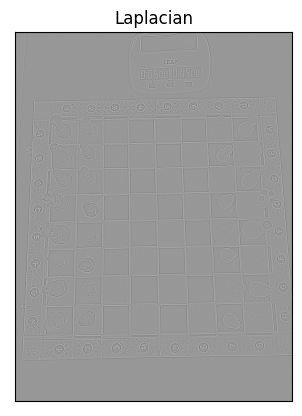

In [12]:
plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

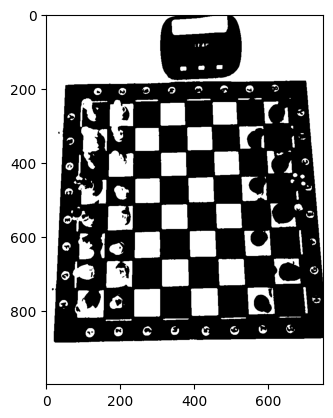

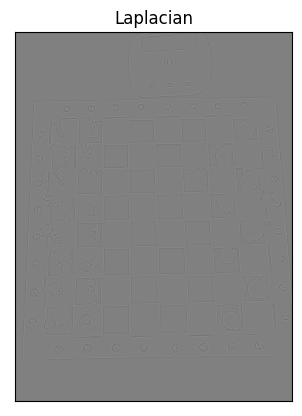

(Text(0.5, 1.0, 'Laplacian'), ([], []), ([], []))

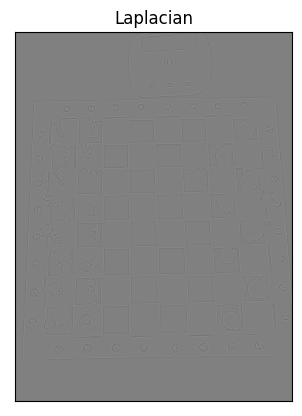

In [19]:
laplacian_binary = cv2.Laplacian(binary_img,cv2.CV_64F)

plt.imshow(laplacian_binary,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.show()

plt.imshow(laplacian_binary*10,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])